# Multi-layers Perceptron for handwritten digits recognition

**Chargement des dépendances**

In [ ]:
import tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Instructions for updating:
non-resource variables are not supported in the long term


**Chargement du dataset**

In [ ]:
train_images=np.fromfile("dataset/mnist/train-images.idx3-ubyte", dtype=np.uint8)[16:].reshape(-1, 784)/255
train_labels=np.eye(10)[np.fromfile("dataset/mnist/train-labels.idx1-ubyte", dtype=np.uint8)[8:]]
test_images=np.fromfile("dataset/mnist/t10k-images.idx3-ubyte", dtype=np.uint8)[16:].reshape(-1, 784)/255
test_labels=np.eye(10)[np.fromfile("dataset/mnist/t10k-labels.idx1-ubyte", dtype=np.uint8)[8:]]

In [ ]:
len(train_images)

60000

Il y a 60 000 images dans notre jeu de données d'entraînements

**Affichage des 10 premières images**

Label: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000]
Digit in the image 5


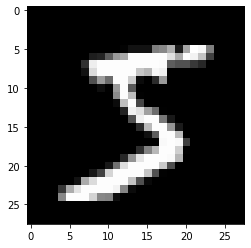

Label: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 0


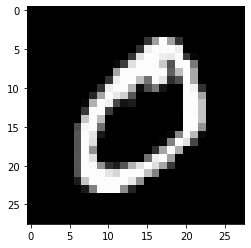

Label: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 4


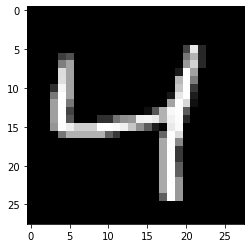

Label: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 1


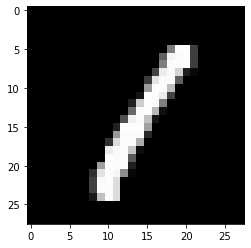

Label: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]
Digit in the image 9


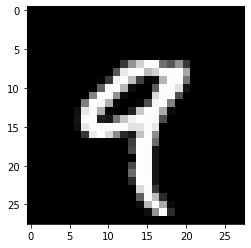

Label: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 2


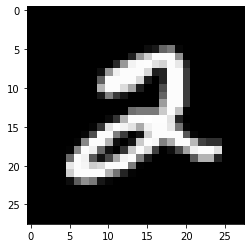

Label: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 1


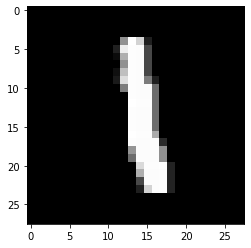

Label: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 3


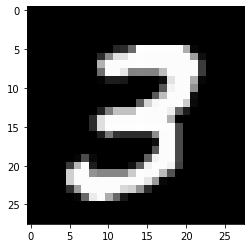

Label: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 1


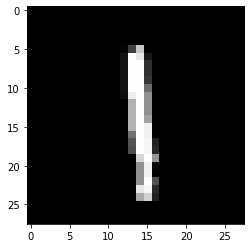

Label: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]
Digit in the image 4


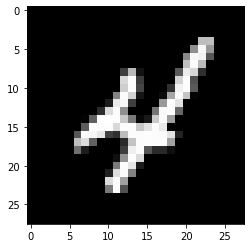

In [ ]:
images = train_images[:10]
labels = train_labels[:10]

%matplotlib inline

for index, image in enumerate(images):
    print("Label:",labels[index])
    print("Digit in the image", np.argmax(labels[index]))
    plt.imshow(image.reshape(28,28),cmap='gray')
    plt.show()

**Architecture du réseau neuronal**

In [ ]:
# Ces 2 placeholders représentent les endroits où seront placés l'image d'entrée et le résultat du réseau
ph_images=tf.placeholder(shape=(None, 784), dtype=tf.float32)
ph_labels=tf.placeholder(shape=(None, 10), dtype=tf.float32)

# Paramètres du réseau
nbr_ni=128                # Nombre de neuronnes
learning_rate=0.0001
taille_batch=100
nbr_entrainement=200

"""
# On définit les différents poids du réseau wci, les différents biais bci
# Les valeurs initiales des bci sont initialisées à 0
wci=tf.Variable(tf.truncated_normal(shape=(784, nbr_ni)), dtype=tf.float32)
bci=tf.Variable(np.zeros(shape=(nbr_ni)), dtype=tf.float32)

# sci est d'abord le résultat de la somme pondrée des entrées, puis sci passe dans la fonction d'activation (sigmoid)
sci=tf.matmul(ph_images, wci)+bci
sci=tf.nn.sigmoid(sci)

# Idem que précédemment mais pour les poids et les biais de sortie
wcs=tf.Variable(tf.truncated_normal(shape=(nbr_ni, 10)), dtype=tf.float32)
bcs=tf.Variable(np.zeros(shape=(10)), dtype=tf.float32)
scs=tf.matmul(sci, wcs)+bcs
scso=tf.nn.softmax(scs)

# Phase d'apprentissage :
# On définit une fonction de perte à optimiser (loss) et la méthode d'optimisation (GradientDescentOptimizer)
# La fonction de loss est définie comme la crosse entropie
loss=tf.nn.softmax_cross_entropy_with_logits_v2(labels=ph_labels, logits=scs)
train=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(scso, 1), tf.argmax(ph_labels, 1)), dtype=tf.float32))
"""

In [ ]:
# Fonction pour ajouter une couche, les paramètres sont : le flux de donnée entrant (input), la taille du flux (size_in) et la taille de la couche de neurones (size_out).
def fcl(input,size_in,size_out):
    W = tf.Variable(tf.truncated_normal([size_in,size_out], stddev=0.1))
    b = tf.Variable(tf.constant(0.1,shape=[1,size_out]))
    output = tf.matmul(input, W)
    output = tf.add(output, b)
    return output

# Couche 1
layer_1 = fcl(ph_images,784,128)
layer_1 = tf.nn.relu(layer_1) #max(x,0)

# Couche 2
layer_2 = fcl(layer_1,128,64)
layer_2 = tf.nn.relu(layer_2)

scs = fcl(layer_2,64,10)

loss=tf.nn.softmax_cross_entropy_with_logits_v2(labels=ph_labels, logits=scs)
train=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(scs, 1), tf.argmax(ph_labels, 1)), dtype=tf.float32))

In [ ]:
# Cette session regroupe les différentes itérations d'apprentissage et les prédictions sur la base de test :
# Fonction qui entraînera notre modèle
with tf.Session() as s:

    # Initialisation des variables
    s.run(tf.global_variables_initializer())

    tab_acc_train=[]
    tab_acc_test=[]

    for id_entrainement in range(nbr_entrainement):
        print("ID entrainement", id_entrainement)
        for batch in range(0, len(train_images), taille_batch):
            # lancement de l'apprentissage en passant la commande "train". feed_dict est l'option désignant ce qui est
            # placé dans les placeholders
            s.run(train, feed_dict={
                ph_images: train_images[batch:batch+taille_batch],
                ph_labels: train_labels[batch:batch+taille_batch]
            })

        # Prédiction du modèle sur les batchs du dataset de training
        tab_acc=[]
        for batch in range(0, len(train_images), taille_batch):
            # lancement de la prédiction en passant la commande "accuracy". feed_dict est l'option désignant ce qui est
            # placé dans les placeholders
            acc=s.run(accuracy, feed_dict={
                ph_images: train_images[batch:batch+taille_batch],
                ph_labels: train_labels[batch:batch+taille_batch]
            })
            # création le tableau des accuracies
            tab_acc.append(acc)

        # calcul de la moyenne des accuracies
        print("accuracy train:", np.mean(tab_acc))
        tab_acc_train.append(1-np.mean(tab_acc))

        # Prédiction du modèle sur les batchs du dataset de test
        tab_acc=[]
        for batch in range(0, len(test_images), taille_batch):
            acc=s.run(accuracy, feed_dict={
                ph_images: test_images[batch:batch+taille_batch],
                ph_labels: test_labels[batch:batch+taille_batch]
            })
            tab_acc.append(acc)
        print("accuracy test :", np.mean(tab_acc))
        tab_acc_test.append(1-np.mean(tab_acc))
        resulat=s.run(scs, feed_dict={ph_images: test_images[0:taille_batch]})
        # Dernière ligne applique de modèle obtenu sur un batch d'images de test. Le résultat sera ensuite affiché (courbe et décision).

ID entrainement 0
accuracy train: 0.8099167
accuracy test : 0.8173
ID entrainement 1
accuracy train: 0.86628336
accuracy test : 0.8706
ID entrainement 2
accuracy train: 0.8874833
accuracy test : 0.89239997
ID entrainement 3
accuracy train: 0.8990333
accuracy test : 0.9026001
ID entrainement 4
accuracy train: 0.9076
accuracy test : 0.90949994
ID entrainement 5
accuracy train: 0.91353333
accuracy test : 0.9157
ID entrainement 6
accuracy train: 0.91835004
accuracy test : 0.92
ID entrainement 7
accuracy train: 0.92241657
accuracy test : 0.9244
ID entrainement 8
accuracy train: 0.92630005
accuracy test : 0.9273
ID entrainement 9
accuracy train: 0.92963326
accuracy test : 0.93109995
ID entrainement 10
accuracy train: 0.9324666
accuracy test : 0.9342
ID entrainement 11
accuracy train: 0.93523335
accuracy test : 0.93619996
ID entrainement 12
accuracy train: 0.9376166
accuracy test : 0.93860006
ID entrainement 13
accuracy train: 0.93985
accuracy test : 0.9407
ID entrainement 14
accuracy train: 

**Affichage de la courbe de l'évolution de l'apprentissage au cours des itérations**

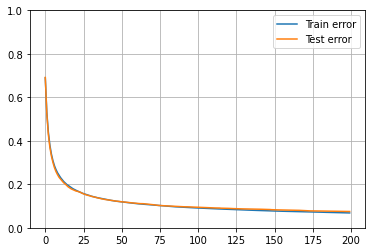

In [ ]:
plt.ylim(0, 1)
plt.grid()
plt.plot(tab_acc_train, label="Train error")
plt.plot(tab_acc_test, label="Test error")
plt.legend(loc="upper right")
plt.show()

**Affichage du résultat obtenu pour chaque image test du batch**

In [ ]:
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
for image in range(taille_batch):
     print("image", image)
     print("sortie du réseau:", resulat[image], np.argmax(resulat[image]))
     print("sortie attendue :", test_labels[image], np.argmax(test_labels[image]))
     cv2_imshow(test_images[image].reshape(28, 28))
     if cv2.waitKey()&0xFF==ord('q'):
         break

image 0
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 1
sortie du réseau: [0.003 0.000 0.990 0.000 0.000 0.003 0.001 0.000 0.002 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 2
sortie du réseau: [0.000 0.980 0.018 0.000 0.000 0.000 0.001 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 3
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 4
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 5
sortie du réseau: [0.000 0.988 0.002 0.001 0.000 0.000 0.000 0.007 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 6
sortie du réseau: [0.000 0.000 0.000 0.000 0.958 0.004 0.000 0.000 0.037 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 7
sortie du réseau: [0.000 0.156 0.000 0.003 0.023 0.153 0.000 0.026 0.005 0.633] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 8
sortie du réseau: [0.000 0.000 0.000 0.000 0.017 0.000 0.981 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 9
sortie du réseau: [0.000 0.000 0.000 0.000 0.003 0.000 0.000 0.068 0.002 0.927] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 10
sortie du réseau: [0.995 0.000 0.000 0.000 0.000 0.004 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 11
sortie du réseau: [0.004 0.000 0.001 0.000 0.001 0.014 0.951 0.000 0.028 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 12
sortie du réseau: [0.000 0.000 0.000 0.000 0.027 0.000 0.000 0.007 0.000 0.965] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 13
sortie du réseau: [0.996 0.000 0.000 0.000 0.000 0.002 0.000 0.000 0.001 0.001] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 14
sortie du réseau: [0.000 0.997 0.000 0.002 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 15
sortie du réseau: [0.001 0.000 0.002 0.066 0.003 0.714 0.000 0.001 0.212 0.001] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 16
sortie du réseau: [0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.001 0.000 0.997] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 17
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 18
sortie du réseau: [0.000 0.000 0.001 0.995 0.000 0.000 0.001 0.000 0.001 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 19
sortie du réseau: [0.000 0.000 0.000 0.000 0.996 0.000 0.000 0.000 0.000 0.004] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 20
sortie du réseau: [0.000 0.000 0.000 0.000 0.013 0.000 0.000 0.033 0.001 0.953] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 21
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.001 0.999 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 22
sortie du réseau: [0.000 0.001 0.005 0.000 0.109 0.000 0.874 0.007 0.003 0.001] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 23
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.997 0.001 0.000 0.001 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 24
sortie du réseau: [0.000 0.000 0.000 0.000 0.985 0.000 0.000 0.014 0.000 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 25
sortie du réseau: [0.999 0.000 0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 26
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.001 0.000 0.984 0.000 0.015] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 27
sortie du réseau: [0.000 0.000 0.003 0.001 0.896 0.049 0.000 0.000 0.010 0.040] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 28
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 29
sortie du réseau: [0.000 0.939 0.000 0.010 0.000 0.045 0.001 0.000 0.005 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 30
sortie du réseau: [0.000 0.001 0.000 0.956 0.000 0.034 0.000 0.005 0.000 0.003] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 31
sortie du réseau: [0.000 0.998 0.000 0.001 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 32
sortie du réseau: [0.000 0.000 0.000 0.998 0.000 0.002 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 33
sortie du réseau: [0.752 0.000 0.003 0.000 0.033 0.052 0.159 0.000 0.001 0.000] 0
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 34
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 35
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 36
sortie du réseau: [0.000 0.000 0.001 0.003 0.000 0.000 0.000 0.995 0.000 0.001] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 37
sortie du réseau: [0.000 0.999 0.000 0.001 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 38
sortie du réseau: [0.005 0.002 0.720 0.106 0.000 0.133 0.030 0.000 0.004 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 39
sortie du réseau: [0.000 0.980 0.000 0.001 0.000 0.000 0.000 0.000 0.018 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 40
sortie du réseau: [0.000 0.989 0.001 0.007 0.000 0.000 0.000 0.000 0.001 0.001] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 41
sortie du réseau: [0.000 0.000 0.016 0.000 0.000 0.000 0.000 0.982 0.000 0.002] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 42
sortie du réseau: [0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 43
sortie du réseau: [0.000 0.000 0.991 0.001 0.000 0.000 0.003 0.000 0.006 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 44
sortie du réseau: [0.000 0.004 0.002 0.972 0.001 0.006 0.005 0.000 0.007 0.003] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 45
sortie du réseau: [0.000 0.000 0.000 0.005 0.000 0.989 0.000 0.000 0.005 0.001] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 46
sortie du réseau: [0.000 0.952 0.010 0.033 0.000 0.002 0.000 0.000 0.002 0.001] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 47
sortie du réseau: [0.000 0.008 0.988 0.000 0.001 0.000 0.000 0.000 0.000 0.003] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 48
sortie du réseau: [0.000 0.000 0.000 0.000 0.995 0.000 0.000 0.000 0.000 0.005] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 49
sortie du réseau: [0.000 0.000 0.000 0.000 0.990 0.000 0.000 0.000 0.001 0.009] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 50
sortie du réseau: [0.001 0.000 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 51
sortie du réseau: [0.000 0.000 0.000 0.998 0.000 0.001 0.000 0.000 0.001 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 52
sortie du réseau: [0.119 0.000 0.000 0.003 0.000 0.833 0.014 0.001 0.027 0.003] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 53
sortie du réseau: [0.000 0.000 0.000 0.000 0.002 0.997 0.000 0.000 0.001 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 54
sortie du réseau: [0.000 0.000 0.001 0.000 0.001 0.000 0.996 0.000 0.002 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 55
sortie du réseau: [0.972 0.000 0.000 0.000 0.000 0.018 0.000 0.000 0.009 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 56
sortie du réseau: [0.000 0.000 0.000 0.000 0.996 0.000 0.001 0.000 0.001 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 57
sortie du réseau: [0.000 0.969 0.026 0.001 0.000 0.000 0.000 0.001 0.002 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 58
sortie du réseau: [0.000 0.000 0.000 0.000 0.002 0.000 0.000 0.002 0.000 0.997] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 59
sortie du réseau: [0.004 0.000 0.001 0.002 0.004 0.978 0.000 0.006 0.003 0.002] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 60
sortie du réseau: [0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.999 0.000 0.001] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 61
sortie du réseau: [0.000 0.000 0.065 0.000 0.000 0.001 0.009 0.000 0.912 0.012] 8
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000] 8


image 62
sortie du réseau: [0.000 0.022 0.003 0.009 0.147 0.338 0.055 0.004 0.086 0.337] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 63
sortie du réseau: [0.000 0.041 0.441 0.295 0.003 0.004 0.003 0.000 0.210 0.003] 2
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 64
sortie du réseau: [0.000 0.000 0.006 0.001 0.000 0.000 0.000 0.992 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 65
sortie du réseau: [0.000 0.001 0.000 0.007 0.896 0.010 0.021 0.000 0.001 0.064] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 66
sortie du réseau: [0.000 0.010 0.334 0.003 0.012 0.005 0.617 0.015 0.001 0.004] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 67
sortie du réseau: [0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 68
sortie du réseau: [0.000 0.000 0.000 0.997 0.000 0.000 0.000 0.000 0.002 0.001] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 69
sortie du réseau: [0.998 0.000 0.001 0.000 0.000 0.001 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 70
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 71
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 72
sortie du réseau: [0.003 0.000 0.955 0.041 0.000 0.000 0.000 0.000 0.001 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 73
sortie du réseau: [0.001 0.000 0.010 0.020 0.000 0.001 0.000 0.307 0.026 0.636] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 74
sortie du réseau: [0.000 0.998 0.000 0.000 0.000 0.000 0.000 0.000 0.001 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 75
sortie du réseau: [0.000 0.000 0.000 0.001 0.001 0.000 0.000 0.997 0.000 0.001] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 76
sortie du réseau: [0.000 0.000 0.000 0.990 0.000 0.005 0.000 0.000 0.006 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 77
sortie du réseau: [0.000 0.000 0.989 0.000 0.000 0.000 0.000 0.006 0.003 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 78
sortie du réseau: [0.000 0.000 0.000 0.002 0.021 0.000 0.000 0.003 0.041 0.933] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 79
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998 0.000 0.002] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 80
sortie du réseau: [0.000 0.000 0.000 0.001 0.001 0.000 0.000 0.662 0.000 0.336] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 81
sortie du réseau: [0.000 0.000 0.001 0.000 0.000 0.016 0.982 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 82
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 83
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.988 0.000 0.012] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 84
sortie du réseau: [0.000 0.000 0.000 0.000 0.004 0.094 0.000 0.000 0.900 0.001] 8
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000] 8


image 85
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 86
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 87
sortie du réseau: [0.000 0.000 0.000 0.759 0.016 0.215 0.002 0.001 0.002 0.005] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 88
sortie du réseau: [0.000 0.000 0.000 0.000 0.001 0.000 0.999 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 89
sortie du réseau: [0.000 0.997 0.001 0.001 0.000 0.000 0.000 0.000 0.001 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 90
sortie du réseau: [0.000 0.000 0.001 0.841 0.000 0.016 0.000 0.001 0.007 0.135] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 91
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 92
sortie du réseau: [0.000 0.000 0.000 0.002 0.331 0.013 0.000 0.006 0.286 0.362] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 93
sortie du réseau: [0.000 0.000 0.000 0.988 0.000 0.001 0.000 0.002 0.006 0.003] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 94
sortie du réseau: [0.000 0.932 0.000 0.000 0.000 0.000 0.000 0.000 0.067 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 95
sortie du réseau: [0.000 0.000 0.000 0.000 0.970 0.000 0.000 0.000 0.001 0.029] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 96
sortie du réseau: [0.000 0.998 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 97
sortie du réseau: [0.000 0.002 0.001 0.003 0.019 0.000 0.000 0.964 0.009 0.002] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 98
sortie du réseau: [0.000 0.000 0.001 0.000 0.000 0.000 0.999 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 99
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.999] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9
